# 02 – Graph Construction

Builds the directed weighted bike network from the cleaned April 2021 trips and computes the statistics required for the report.

## Objectives
- load the cleaned trip data
- aggregate trips into directed edges with trip, distance, and duration weights
- construct the directed graph with station metadata
- compute connectivity, reciprocity, and degree distributions
- export tidy summary tables for use in the written report

In [1]:
from pathlib import Path

import networkx as nx
import pandas as pd

# Resolve project paths so the notebook works whether it is run from the repo root or inside /notebooks
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / 'data').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PATH = PROJECT_ROOT / 'data' / '2021-04_cleaned.csv'
OUTPUT_DIR = PROJECT_ROOT / 'data' / 'graph_summary'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Using data file: {DATA_PATH}")
print(f"Summary tables will be written to: {OUTPUT_DIR}")

Using data file: /Users/elifdeniz/Desktop/Network-Science---Helsinki-City-Bikes---UZH/data/2021-04_cleaned.csv
Summary tables will be written to: /Users/elifdeniz/Desktop/Network-Science---Helsinki-City-Bikes---UZH/data/graph_summary


In [2]:
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df):,} trips covering {df['Departure station id'].nunique()} departure stations and {df['Return station id'].nunique()} return stations.")
df.head()

Loaded 258,514 trips covering 351 departure stations and 351 return stations.


,Departure,Return,Departure station id,Departure station name,Return station id,Return station name,Covered distance (m),Duration (sec.),new_duration
0,2021-04-30T23:59:54,2021-05-01T00:08:15,16,Liisanpuistikko,2,Laivasillankatu,1885.0,499,501
1,2021-04-30T23:59:52,2021-05-01T00:13:40,4,Viiskulma,33,Kauppakorkeakoulu,1633.0,824,828
2,2021-04-30T23:59:52,2021-05-01T00:16:16,20,Kaisaniemenpuisto,112,Rautatieläisenkatu,3359.0,984,984
3,2021-04-30T23:59:43,2021-05-01T00:23:22,133,Paavalinpuisto,241,Agronominkatu,6459.0,1418,1419
4,2021-04-30T23:59:41,2021-05-01T00:16:15,20,Kaisaniemenpuisto,112,Rautatieläisenkatu,3210.0,990,994


In [7]:
# Build the station master table so each node includes its readable name
stations_dep = df[['Departure station id', 'Departure station name']].drop_duplicates()
stations_dep.columns = ['station_id', 'station_name']
stations_ret = df[['Return station id', 'Return station name']].drop_duplicates()
stations_ret.columns = ['station_id', 'station_name']
stations_df = pd.concat([stations_dep, stations_ret], ignore_index=True)
stations_df = stations_df.drop_duplicates(subset='station_id').sort_values('station_id').reset_index(drop=True)

# Aggregate trips into weighted directed edges
edge_df = (
    df.groupby(['Departure station id', 'Return station id'], as_index=False)
      .agg(trip_count=('Departure station id', 'size'),
           total_distance_m=('Covered distance (m)', 'sum'),
           total_duration_s=('new_duration', 'sum'))
)

print(f"Prepared {len(stations_df)} nodes and {len(edge_df):,} weighted edges")
edge_df.head()

Prepared 351 nodes and 32,815 weighted edges


,Departure station id,Return station id,trip_count,total_distance_m,total_duration_s
0,1,1,96,174070.0,117899
1,1,2,20,39187.0,21620
2,1,3,24,58602.0,31752
3,1,4,28,46149.0,19372
4,1,5,25,39389.0,28926


In [8]:
# Construct the directed weighted network
G = nx.DiGraph()
for _, row in stations_df.iterrows():
    G.add_node(int(row['station_id']), station_name=row['station_name'])

for _, row in edge_df.iterrows():
    G.add_edge(int(row['Departure station id']), int(row['Return station id']),
               trip_count=int(row['trip_count']),
               total_distance_m=float(row['total_distance_m']),
               total_duration_s=float(row['total_duration_s']))

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Graph constructed with {num_nodes} nodes and {num_edges:,} directed edges")

Graph constructed with 351 nodes and 32,815 directed edges


In [ ]:
# Strongly and weakly connected components
strong_components = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
weak_components = sorted(nx.weakly_connected_components(G), key=len, reverse=True)

component_rows = []
for comp_type, components in [('strong', strong_components), ('weak', weak_components)]:
    for idx, nodes in enumerate(components, start=1):
        component_rows.append({
            'component_type': comp_type,
            'component_id': idx,
            'size': len(nodes),
            'sample_station_ids': ', '.join(map(str, list(nodes)[:5]))
        })

component_summary = pd.DataFrame(component_rows)
print(f"Strong components: {len(strong_components)} | Weak components: {len(weak_components)}")
component_summary.head() #???

Strong components: 1 | Weak components: 1


,component_type,component_id,size,sample_station_ids
0,strong,1,351,"1, 2, 3, 4, 5"
1,weak,1,351,"1, 2, 3, 4, 5"


In [10]:
# Reciprocity and graph-wide overview statistics
reciprocity = nx.reciprocity(G)

graph_overview = pd.DataFrame([{
    'num_nodes': G.number_of_nodes(),
    'num_edges': G.number_of_edges(),
    'total_trips': len(df),
    'total_distance_m': df['Covered distance (m)'].sum(),
    'total_duration_s': df['new_duration'].sum(),
    'average_trip_distance_m': df['Covered distance (m)'].mean(),
    'average_trip_duration_s': df['new_duration'].mean(),
    'reciprocity': reciprocity,
    'num_strong_components': len(strong_components),
    'num_weak_components': len(weak_components)
}])

graph_overview

,num_nodes,num_edges,total_trips,total_distance_m,total_duration_s,average_trip_distance_m,average_trip_duration_s,reciprocity,num_strong_components,num_weak_components
0,351,32815,258514,672915898.0,231745251,2603.015303,896.451453,0.787628,1,1


In [11]:
# Degree distributions (unweighted and weighted by trip count)
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())
weighted_in_degree = dict(G.in_degree(weight='trip_count'))
weighted_out_degree = dict(G.out_degree(weight='trip_count'))

degree_summary = stations_df.copy()
degree_summary['in_degree'] = degree_summary['station_id'].map(in_degree).fillna(0).astype(int)
degree_summary['out_degree'] = degree_summary['station_id'].map(out_degree).fillna(0).astype(int)
degree_summary['weighted_in_degree'] = degree_summary['station_id'].map(weighted_in_degree).fillna(0).astype(int)
degree_summary['weighted_out_degree'] = degree_summary['station_id'].map(weighted_out_degree).fillna(0).astype(int)

degree_summary = degree_summary.sort_values('weighted_out_degree', ascending=False).reset_index(drop=True)
degree_summary.head()

,station_id,station_name,in_degree,out_degree,weighted_in_degree,weighted_out_degree
0,30,Itämerentori,183,171,4933,4799
1,113,Pasilan asema,200,195,3136,3684
2,126,Kalasatama (M),192,186,3894,3529
3,41,Ympyrätalo,199,191,3560,3330
4,21,Töölönlahdenkatu,169,164,2917,2689


In [12]:
# Persist tidy tables for inclusion in the report
edge_output = OUTPUT_DIR / 'edge_aggregates.csv'
degree_output = OUTPUT_DIR / 'degree_summary.csv'
component_output = OUTPUT_DIR / 'component_summary.csv'
overview_output = OUTPUT_DIR / 'graph_overview.csv'

edge_df.to_csv(edge_output, index=False)
degree_summary.to_csv(degree_output, index=False)
component_summary.to_csv(component_output, index=False)
graph_overview.to_csv(overview_output, index=False)

print('Saved outputs:')
print(' -', edge_output.name)
print(' -', degree_output.name)
print(' -', component_output.name)
print(' -', overview_output.name)

Saved outputs:
 - edge_aggregates.csv
 - degree_summary.csv
 - component_summary.csv
 - graph_overview.csv


In [2]:
import pandas as pd
import networkx as nx

df = pd.read_csv("../data/2021-04_cleaned.csv")

df = df.rename(columns={"Departure": "departure_time", "Return": "return_time", "Departure station id": "dep_id", "Departure station name": "dep_name",
    "Return station id": "ret_id", "Return station name": "ret_name", "Covered distance (m)": "distance_m", "Duration (sec.)": "duration_s"})

df = df[(df["distance_m"] > 0) & (df["duration_s"] > 0)]
df = df.dropna(subset=["dep_id", "ret_id"])

G = nx.DiGraph()

for _, row in df[["dep_id", "dep_name"]].drop_duplicates().iterrows():
    G.add_node(row["dep_id"], name=row["dep_name"])

for _, row in df[["ret_id", "ret_name"]].drop_duplicates().iterrows():
    G.add_node(row["ret_id"], name=row["ret_name"])

agg = df.groupby(["dep_id", "ret_id"]).agg(trip_count=("dep_id", "size"),
    total_distance=("distance_m", "sum"), total_duration=("duration_s", "sum")).reset_index()

for _, r in agg.iterrows():
    G.add_edge(r["dep_id"], r["ret_id"], weight=r["trip_count"],
               total_distance=r["total_distance"], total_duration=r["total_duration"])

print("Number of nodes (stations):", G.number_of_nodes())
print("Number of edges (station pairs):", G.number_of_edges())
print("Total trips:", df.shape[0])
print("Average trip distance (m):", df["distance_m"].mean())
print("Average trip duration (s):", df["duration_s"].mean())

in_deg = G.in_degree(weight="weight")
out_deg = G.out_degree(weight="weight")

top_inbound = sorted(in_deg, key=lambda x: x[1], reverse=True)[:5]
top_outbound = sorted(out_deg, key=lambda x: x[1], reverse=True)[:5]

print("\nTop inbound stations (by trips arriving):")
for node, val in top_inbound:
    print(G.nodes[node]["name"], ":", val)

print("\nTop outbound stations (by trips departing):")
for node, val in top_outbound:
    print(G.nodes[node]["name"], ":", val)

print("\nIs the graph strongly connected?", nx.is_strongly_connected(G))
df.columns


Number of nodes (stations): 351
Number of edges (station pairs): 32815
Total trips: 258514
Average trip distance (m): 2603.0153028462673
Average trip duration (s): 850.905575713501

Top inbound stations (by trips arriving):
Itämerentori : 4933.0
Kalasatama (M) : 3894.0
Ympyrätalo : 3560.0
Pasilan asema : 3136.0
Töölönlahdenkatu : 2917.0

Top outbound stations (by trips departing):
Itämerentori : 4799.0
Pasilan asema : 3684.0
Kalasatama (M) : 3529.0
Ympyrätalo : 3330.0
Töölönlahdenkatu : 2689.0

Is the graph strongly connected? True


Index(['departure_time', 'return_time', 'dep_id', 'dep_name', 'ret_id',
       'ret_name', 'distance_m', 'duration_s', 'Departure_lat',
       'Departure_lon', 'Return_lat', 'Return_lon', 'new_duration',
       'Speed_kmh'],
      dtype='object')

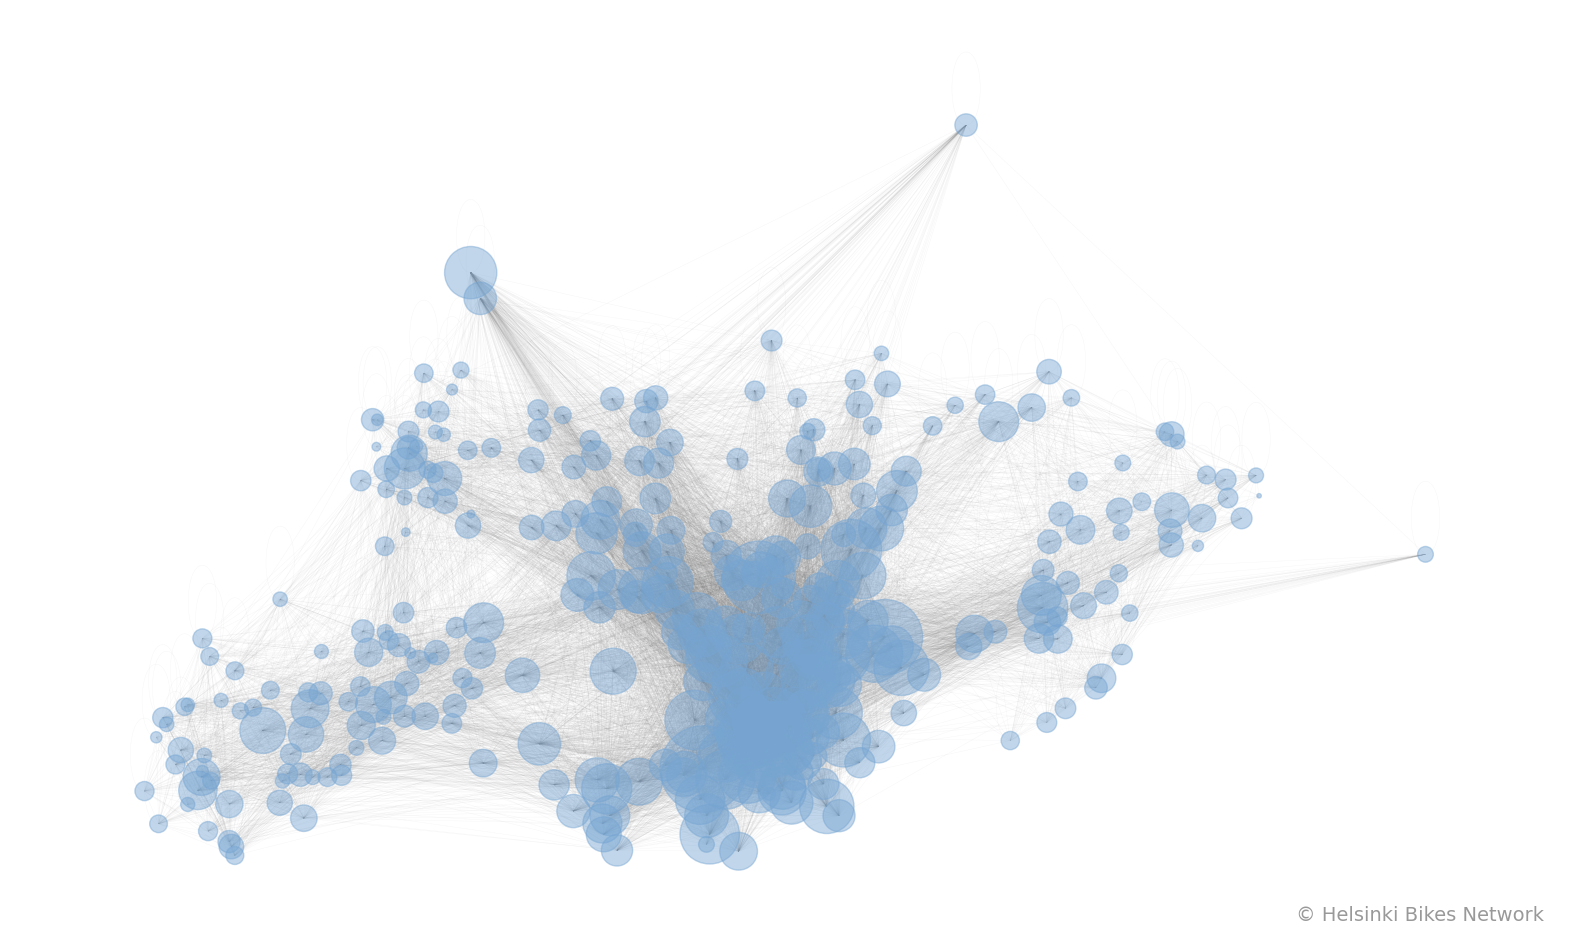

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

def bike_network_clean(df, year=2021):
    """
    Clean, map-style bike network visualization 
    similar to Github/Geometrein example.
    """

    df = df.copy()
    df["departure_time"] = pd.to_datetime(df["departure_time"])
    df = df[df["departure_time"].dt.year == year]

    # Remove invalid rows
    df = df.dropna(subset=[
        "dep_id", "ret_id",
        "Departure_lat", "Departure_lon",
        "Return_lat", "Return_lon"
    ])

    # Use UNDIRECTED graph for clean visualization
    G = nx.Graph()

    # Add edges
    for _, r in df.iterrows():
        G.add_edge(
            r["dep_id"],
            r["ret_id"],
            distance=r["distance_m"],
            duration=r["duration_s"]
        )

    # Add node positions (GPS coordinates)
    for _, r in df.drop_duplicates(subset=["dep_id"])[["dep_id", "Departure_lat", "Departure_lon", "dep_name"]].iterrows():
        G.nodes[r["dep_id"]]["pos"] = (r["Departure_lon"], r["Departure_lat"])
        G.nodes[r["dep_id"]]["name"] = r["dep_name"]

    for _, r in df.drop_duplicates(subset=["ret_id"])[["ret_id", "Return_lat", "Return_lon", "ret_name"]].iterrows():
        G.nodes[r["ret_id"]]["pos"] = (r["Return_lon"], r["Return_lat"])
        G.nodes[r["ret_id"]]["name"] = r["ret_name"]

    # Positions for plotting
    pos = nx.get_node_attributes(G, "pos")

    # Node sizes based on station popularity
    counts = df["dep_id"].value_counts() + df["ret_id"].value_counts()
    node_sizes = [counts.get(n, 1) * 0.4 for n in G.nodes()]  # scale down

    # FIGURE
    fig, ax = plt.subplots(figsize=(20, 12))

    # Draw nodes
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes,
        node_color="#76A5D2",
        alpha=0.45
    )

    # Draw edges: faint, thin, undirected edges
    nx.draw_networkx_edges(
        G,
        pos,
        edge_color="grey",
        width=0.3,
        alpha=0.08  # VERY FAINT, like the good example
    )

    ax.axis("off")

    # Optional watermark
    ax.text(
        0.99, 0.01,
        "© Helsinki Bikes Network",
        ha="right", va="bottom",
        fontsize=14, color="grey", alpha=0.8,
        transform=ax.transAxes
    )

    plt.show()
    return G

G = bike_network_clean(df, year=2021)

The notebook has now constructed the directed weighted bike network, computed the requested graph measures, and exported reusable summary tables for the report. Re-run any cell after updating the cleaned dataset to refresh the metrics.